# HandySpark

### Bringing pandas-like capabilities to Spark dataframes!

In [1]:
# UNCOMMENT THIS IF YOU'RE USING GOOGLE COLAB!

#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q http://apache.osuosl.org/spark/spark-2.3.3/spark-2.3.3-bin-hadoop2.7.tgz
#!tar xf spark-2.3.3-bin-hadoop2.7.tgz
#!pip install -q pyspark==2.3.3
#!pip install -q findspark
#!pip install -q handyspark

#import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-2.3.3-bin-hadoop2.7"

In [2]:
!wget https://raw.githubusercontent.com/dvgodoy/handyspark/master/tests/rawdata/train.csv

In [3]:
import os
import numpy as np
import findspark
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from handyspark import *
from matplotlib import pyplot as plt
# fixes issue with seaborn hiding fliers on boxplot
import matplotlib as mpl
mpl.rc("lines", markeredgewidth=0.5)

findspark.init()
os.environ['PYSPARK_SUBMIT_ARGS'] = '--master local[*] pyspark-shell'

%matplotlib inline

spark = SparkSession.builder.getOrCreate()

# 1. Loading Data into a `HandyFrame`

### After loading data as usual, just call method `toHandy()` (an extension to Spark's dataframe)!

In [4]:
sdf = spark.read.csv('train.csv', header=True, inferSchema=True)
hdf = sdf.toHandy()
hdf

HandyFrame[PassengerId: int, Survived: int, Pclass: int, Name: string, Sex: string, Age: double, SibSp: int, Parch: int, Ticket: string, Fare: double, Cabin: string, Embarked: string]

## Fetching some data

- using an instance of `cols` from your `HandyFrame`, you can retrieve values for given columns in the top N rows

#### Single column will be returned as a pandas Series

In [5]:
hdf.cols['Name'][:5]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

#### Multiple columns will be returned as a pandas DataFrame

In [6]:
hdf.cols[['Name', 'Pclass']][:5]

,Name,Pclass
0,"Braund, Mr. Owen Harris",3
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1
2,"Heikkinen, Miss. Laina",3
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1
4,"Allen, Mr. William Henry",3


#### You can also use `:` to get all columns!

In [7]:
hdf.cols[:][:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


# 2. Exploratory Data Analysis

## Checking for missing values

In [8]:
hdf.isnull(ratio=True)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
Name: missing(ratio), dtype: float64

### Let's check the value counts for `Embarked`

In [9]:
hdf.cols['Embarked'].value_counts(dropna=False)

Embarked
C      168
Q       77
S      644
NaN      2
Name: value_counts, dtype: int64

### S (Southampton) is the port where most people Embarked... is it like that for every class?

## 2.1 Enter `stratify`!
### You can now get statistics and more at strata level, without using `groupby`!

In [10]:
hdf.stratify(['Pclass']).cols['Embarked'].value_counts()

Pclass  Embarked
1       C            85
        Q             2
        S           127
2       C            17
        Q             3
        S           164
3       C            66
        Q            72
        S           353
Name: value_counts, dtype: int64

### So, indeed, Southampton is the port where most of people from all classes embarked!

### What about age? Is the average age different depending on `Pclass` and `Sex`? You bet!

In [11]:
hdf.stratify(['Pclass', 'Sex']).cols['Age'].mean()

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

### "`stratify` is cool, but can I use it with continuous values too?" Sure thing!

## 2.2 Enter `Bucket` and `Quantile`!

### You can use any of them to split continuous values into bins for the stratification!

In [12]:
hdf.stratify(['Sex', Bucket('Age', 2)]).cols['Embarked'].value_counts()

Sex     Age                                Embarked
female  Age >= 0.4200 and Age < 40.2100    C            46
                                           Q            12
                                           S           154
        Age >= 40.2100 and Age <= 80.0000  C            15
                                           S            32
male    Age >= 0.4200 and Age < 40.2100    C            53
                                           Q            11
                                           S           287
        Age >= 40.2100 and Age <= 80.0000  C            16
                                           Q             5
                                           S            81
Name: value_counts, dtype: int64

## Let's use `stratify` to perform a `fill` operation

In [13]:
hdf_filled = hdf.stratify(['Pclass', 'Sex']).fill(continuous=['Age'], strategy=['mean'])
hdf_filled = hdf_filled.fill(categorical=['Embarked'])

In [14]:
hdf_filled.isnull()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Name: missing, dtype: int64

### Ok, no more missing values for `Age` and `Embarked`!
### Which values were actually used?

In [15]:
hdf_filled.statistics_

{'Age': {'Pclass == "1" and Sex == "female"': 34.61176470588235,
  'Pclass == "1" and Sex == "male"': 41.28138613861386,
  'Pclass == "2" and Sex == "female"': 28.722972972972972,
  'Pclass == "2" and Sex == "male"': 30.74070707070707,
  'Pclass == "3" and Sex == "female"': 21.75,
  'Pclass == "3" and Sex == "male"': 26.507588932806325},
 'Embarked': 'S'}

### "But I want to use those values to fill the test set as well..."

## 2. 3 Enter the `transformers` generator!

### You can generate a custom PySpark imputer transformer that will perform the stratified filling and it is serializable as well, so you can include it in your pipeline and save / load it at will!

In [16]:
imputer = hdf_filled.transformers.imputer()
imputer.getDictValues()

{'Age': {'Pclass == "1" and Sex == "female"': 34.61176470588235,
  'Pclass == "1" and Sex == "male"': 41.28138613861386,
  'Pclass == "2" and Sex == "female"': 28.722972972972972,
  'Pclass == "2" and Sex == "male"': 30.74070707070707,
  'Pclass == "3" and Sex == "female"': 21.75,
  'Pclass == "3" and Sex == "male"': 26.507588932806325},
 'Embarked': 'S'}

## 2.4 Detecting and fencing outliers

In [17]:
hdf_filled.outliers(method='tukey', k=3.)

PassengerId      0
Survived         0
Pclass           0
Age              1
SibSp           12
Parch          213
Fare            53
Name: outliers, dtype: int64

### There seem to be outliers for several columns... how can we be certain?

## Maybe plotting them?

- Unlike many tutorials on the internet, these plots are generated using Spark's distributed computing capabilities, and ***NOT converting the whole dataset to pandas to plot it*** (which defeats the whole purpose of Spark!)

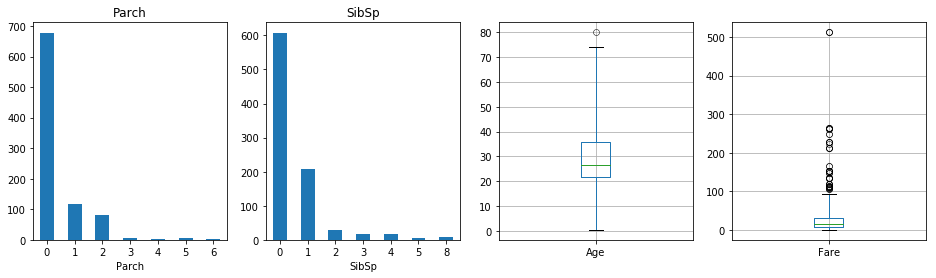

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
hdf_filled.cols['Parch'].hist(ax=axs[0])
hdf_filled.cols['SibSp'].hist(ax=axs[1])
hdf_filled.cols['Age'].boxplot(ax=axs[2], k=3)
hdf_filled.cols['Fare'].boxplot(ax=axs[3], k=3)

### So, it seems Tukey's method was very conservative... let's stick with the `Fare` column only!

### This column has continuous values in a wide range of values... how about taking the `log` of it?

## 2.5 Enter `assign`!

### Using `assign`, it is possible to easily append a new column to the dataframe using a `lambda` function with column name(s) as argument(s)!

### Under the hood, `HandySpark` will convert it to a `pandas udf` for better performance!

In [19]:
hdf_filled = hdf_filled.assign(logFare=lambda Fare: np.log(Fare + 1))

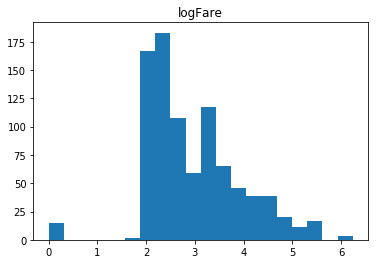

In [20]:
hdf_filled.cols['logFare'].hist(bins=20)

### Those values to the extreme left of the histogram seem suspicious...

### Let's make a stratified boxplot to try spotting outliers!

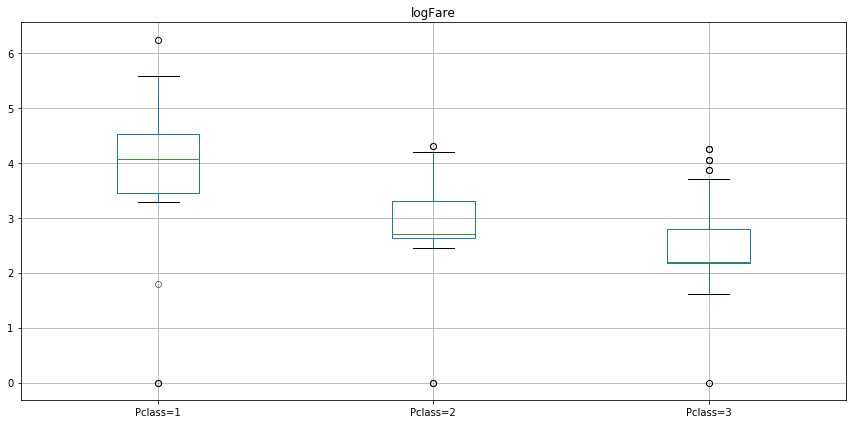

In [21]:
fig, axs = hdf_filled.stratify(['Pclass']).cols['logFare'].boxplot(figsize=(12, 6))

### So, apparently we have some outliers, which are quite different depending on `Pclass`... let's clean them up!

## 2.6 Enter `fence`!

### Using `fence`, you can `cap` values to the lower and upper fence values, according to Tukey's method!

In [22]:
hdf_fenced = hdf_filled.fence(['Fare'])
hdf_fenced.fences_

{'Fare': [-26.0105, 64.4063]}

In [23]:
hdf_fenced = hdf_filled.stratify(['Pclass']).fence(['logFare'])
hdf_fenced.fences_

{'Fare': [-26.0105, 64.4063],
 'logFare': {'Pclass == "1"': [1.856486835561669, 6.122346420708724],
  'Pclass == "2"': [1.6538880250316523, 4.281006170587935],
  'Pclass == "3"': [1.2175936795640057, 3.7548204017120526]}}

### "But I want to use those values to cap outliers in the test set as well..."

## 2.7 Enter the `transformers` generator (again!)

### You can generate a custom PySpark fencer transformer that will perform the stratified fencing!

In [24]:
fencer = hdf_fenced.transformers.fencer()
fencer.getDictValues()

{'Fare': [-26.0105, 64.4063],
 'logFare': {'Pclass == "1"': [1.856486835561669, 6.122346420708724],
  'Pclass == "2"': [1.6538880250316523, 4.281006170587935],
  'Pclass == "3"': [1.2175936795640057, 3.7548204017120526]}}

### How about using `pandas` to append new columns?

## 2.8 Enter the `pandas` object from `HandySpark`!

### Most of column functions are available, like `isin`:

In [25]:
some_ports = hdf_fenced.pandas['Embarked'].isin(values=['C', 'Q'])
some_ports

Column<b'udf(Embarked) AS `<lambda>(Embarked,)`'>

### The corresponding `pandas udf` is automatically generated and can be used directly in an `assign` expression:

In [26]:
hdf_fenced = hdf_fenced.assign(is_c_or_q=some_ports)
hdf_fenced.cols['is_c_or_q'][:5]

0    False
1     True
2    False
3    False
4    False
Name: is_c_or_q, dtype: bool

## Even pandas objects like `str` and `dt` are available, with lots of already supported methods, like `find`:

In [27]:
col_mrs = hdf_fenced.pandas['Name'].str.find(sub='Mrs.')
hdf_fenced.assign(is_mrs=col_mrs > 0).cols[['Name', 'is_mrs']][:5]

,Name,is_mrs
0,"Braund, Mr. Owen Harris",False
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",True
2,"Heikkinen, Miss. Laina",False
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",True
4,"Allen, Mr. William Henry",False


## 2.9 Evaluation

### So, you pre-processed your data and trained your classification model... how good is it?

In [54]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

assem = VectorAssembler(inputCols=['Fare', 'Pclass', 'Age'], outputCol='features')
rf = RandomForestClassifier(featuresCol='features', labelCol='Survived', numTrees=20)
pipeline = Pipeline(stages=[assem, rf])
model = pipeline.fit(hdf_fenced)

predictions = model.transform(hdf_fenced)

evaluator = BinaryClassificationEvaluator(labelCol='Survived')
evaluator.evaluate(predictions)

0.8464432940274191

### This is the Area under the ROC Curve, fine... but what about Precision-Recall curve? Thresholds? Confusion Matrix?

## Enter the (extended) BinaryClassificationMetrics!

In [55]:
bcm = BinaryClassificationMetrics(predictions, scoreCol='probability', labelCol='Survived')

### You can PLOT both ROC and PR curves!

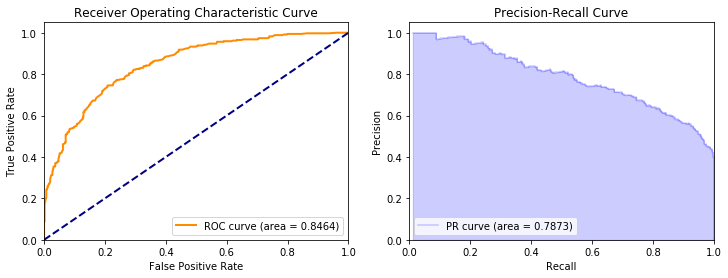

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

### You still have the values for the corresponding areas!

In [48]:
print("Area under ROC Curve: {:.4f}".format(bcm.areaUnderROC))
print("Area under PR Curve: {:.4f}".format(bcm.areaUnderPR))

Area under ROC Curve: 0.8464
Area under PR Curve: 0.7873


### "I want to have a Recall of at least 50%... which threshold should I use then?"

### `getMetricsByThreshold` gives you all possible thresholds and corresponding values in a nice pandas dataframe!

In [30]:
bcm.getMetricsByThreshold().toPandas()[100:105]

,threshold,fpr,recall,precision
100,0.580768,0.071038,0.485380,0.809756
101,0.578074,0.071038,0.491228,0.811594
102,0.577153,0.071038,0.494152,0.812500
103,0.572006,0.071038,0.502924,0.815166
104,0.569174,0.071038,0.505848,0.816038


### Once you choose your threshold, you can check its corresponding Confusion Matrix as well!

In [40]:
bcm.confusionMatrix(.572006)

DenseMatrix(2, 2, [510.0, 176.0, 39.0, 166.0], 0)

In [43]:
bcm.print_confusion_matrix(.572006)

Predicted       
                 0      1
Actual 0     510.0   39.0
       1     176.0  166.0

## 2.10 What else can one do using `HandySpark`?

### Lots of things, these are just a few examples...

### Correlations

In [33]:
strat_corr = hdf_fenced.stratify(['Sex']).cols[:].corr()

In [34]:
strat_corr.loc[pd.IndexSlice[:, 'Survived']]

Sex     index      
female  Age            0.132313
        Fare           0.218466
        Parch         -0.223644
        PassengerId   -0.008790
        Pclass        -0.477114
        SibSp         -0.263284
        Survived       1.000000
        logFare        0.260685
male    Age           -0.091223
        Fare           0.171288
        Parch          0.096318
        PassengerId    0.040477
        Pclass        -0.220618
        SibSp         -0.020238
        Survived       1.000000
        logFare        0.225389
Name: Survived, dtype: float64

### Entropy

In [35]:
hdf_fenced.cols[['Survived', 'Pclass', 'Embarked', 'Sex']].entropy()

Embarked    1.095450
Pclass      1.439321
Sex         0.936205
Survived    0.960708
Name: entropy, dtype: float64

### Mutual Info

In [36]:
hdf_fenced.cols[['Survived', 'Pclass', 'Embarked', 'Sex']].mutual_info()

,Embarked,Pclass,Sex,Survived
,,,,
Embarked,1.095450,0.101276,0.010249,0.020534
Pclass,0.101276,1.439321,0.013710,0.083831
Sex,0.010249,0.013710,0.936205,0.217660
Survived,0.020534,0.083831,0.217660,0.960708


### Stratified histograms

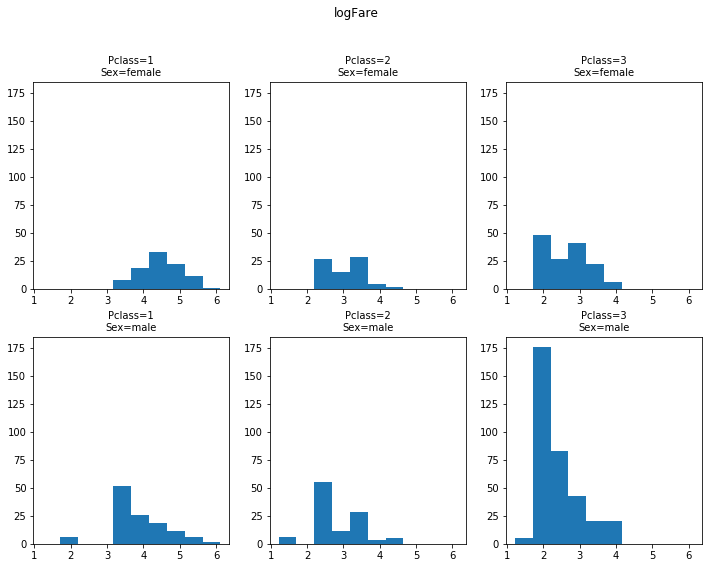

In [37]:
fig, axs = hdf_fenced.stratify(['Pclass', 'Sex']).cols['logFare'].hist(figsize=(10, 8))

### Stratified scatterplots

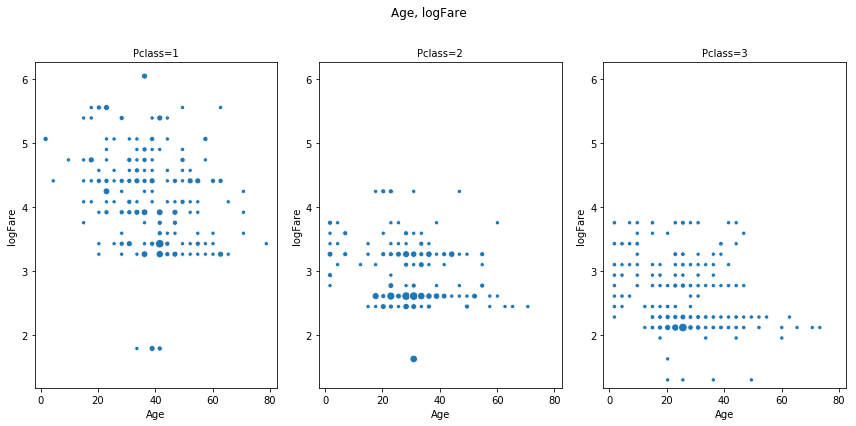

In [38]:
fig, axs = hdf_fenced.stratify(['Pclass']).cols[['Age', 'logFare']].scatterplot(figsize=(12, 6))